v1.0

The objective of this notebook is to:
- evaluate the model's sensitivity regarding **n_estimators**

# Pre-checks

In [1]:
## Check for Google Drive Connectivity
try:
    from google.colab import drive
    drive.mount('/content/drive')
    google_env = True
except:
    print("Not a Goolge Drive Environment.")
    google_env = False

Not a Goolge Drive Environment.


In [2]:
import time
t_start = time.time()

In [3]:
# Use parameters to enable/disable the fastrun

FASTRUN = False
#FASTRUN = True

# Size of the fastrun dataframe
sample_fraction = 0.001
print("==="*40)
print("Fastrun enabled:", FASTRUN)
if FASTRUN: print("Sample size:",sample_fraction)
print("==="*40)


Fastrun enabled: False


# Setup Environment

## Install Modules

In [4]:
#!pip install icecream
#!pip install watermark
#!pip install fastparquet

## Import Modules

In [5]:
# Base libraries
import os
from datetime import date

# Scientific libraries
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=0.8)

# Helper libraries
from watermark import watermark
from icecream import ic
import gc # garbage collection to optimize memory usage: use "gc.collect()"
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Global Parameters

In [6]:
seed = 42
cpu_count = os.cpu_count()
cpu_count = cpu_count-2  # to keep machine responsive when fitting the models
notebook_no = "08.02"
today = date.today()

## Global Helper Functions

In [7]:
import http.client
import urllib


def send_push(message):
    """Send push notifications to pushover service."""
    try:
        conn = http.client.HTTPSConnection("api.pushover.net:443")
        conn.request("POST", "/1/messages.json",
                     urllib.parse.urlencode({
                         "token": "ahs1q4mwpnxe3645zeaqzas69whq7a",  # ML Notifications Channel
                         "user": "u5vr1qkc9ghudg2ehuug153okeiz1d",
                         "message": message,
                     }), {"Content-type": "application/x-www-form-urlencoded"})

        conn.getresponse()

    except:
        print("There was a communication issue (pushover).")


In [8]:
def fast_run_sampling(df, sample_fraction):
    """Return a fraction of the dataset."""
    print("Labels before sampling:\n", df['label'].value_counts())
    df = df.groupby('label').sample(frac=sample_fraction, random_state=seed) 
    #df = df.sample(n=sample_size, random_state=seed).reset_index(drop=True)
    print("Labels after sampling:\n", df['label'].value_counts())
    return df
    

In [9]:
def calculate_duration(t_start, t_end):
    """Return run time in minutes."""
    total_runtime = t_end-t_start
    total_runtime_min = round((total_runtime/60), 2)
    print(str(total_runtime_min)+" minutes")

    return total_runtime_min


# 3.0 Load Data

In [10]:
# Load Data
if google_env:
    # Location for "shared with" people
    # create a shortcut of the shared folder in your Google Drive root folder
    ROOT_PATH = "/content/drive/MyDrive/SIADS696/Environment/"
else:
    ROOT_PATH = "../"
    print("Not a Google Drive Environment. Loading local files.")

PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_DATA_MOD = "models/"
PATH_DATA_REP = "reports/"
PATH_DATA_FIG = "reports/figures/"
PATH_DATA_HTML = "reports/html/"

# Dictionary to store file names and their corresponding dataframes
files = {
    "train_features_clean_stats.parquet.gzip": "df_wiki_train_stats",
    "train_features_rs.parquet.gzip": "df_wiki_train_rs",
    "train_features_nltk.parquet.gzip": "df_wiki_train_nltk",
    "train_features_aoa.parquet.gzip": "df_wiki_train_aoa",
    "train_features_crb.parquet.gzip": "df_wiki_train_crb",
    "train_features_w2v.parquet.gzip": "df_wiki_train_w2v",
   # "train_mNB_predict.parquet.gzip": "df_wiki_train_MNB",  # data leakage risk
   # "test_mNB_predict.parquet.gzip": "df_wiki_test_MNB",    # data leakage risk
}

# Load data into corresponding dataframes
for file, df_name in files.items():
    if df_name not in globals():
        globals()[df_name] = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + file)


Not a Google Drive Environment. Loading local files.


In [11]:
# Combine dataframes into one
df_train = pd.DataFrame()
df_train = pd.concat([df_train, df_wiki_train_stats], axis=1)
df_train = pd.concat([df_train, df_wiki_train_rs], axis=1)
df_train = pd.concat([df_train, df_wiki_train_nltk], axis=1)
df_train = pd.concat([df_train, df_wiki_train_aoa], axis=1)
df_train = pd.concat([df_train, df_wiki_train_crb], axis=1)
df_train = pd.concat([df_train, df_wiki_train_w2v], axis=1)

if FASTRUN:
    df_train = fast_run_sampling(df_train, sample_fraction)


In [12]:
df_train.shape

(416768, 155)

In [13]:
df_rfecv_selected_feature = pd.read_csv(ROOT_PATH+PATH_DATA_INT+"RFECV10-RF-selected_features-table_04.02.csv")
rfecv_selected_feature = sorted(df_rfecv_selected_feature['Selected Features'].to_list())
ic(len(rfecv_selected_feature));


ic| len(rfecv_selected_feature): 125


# Sensitivity Analysis

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from scipy.stats import randint

In [15]:
k=10
skfold = StratifiedKFold(n_splits=k)
scaler = MinMaxScaler((0, 1))
rf = RandomForestClassifier(random_state=seed, n_jobs=-1)

n_iter = 25


In [16]:
X = df_train[rfecv_selected_feature].copy()
y = df_train["label"]

ic(X.shape);
ic(y.shape);


ic| X.shape: (416768, 125)
ic| y.shape: (416768,)


In [17]:
pipeline = Pipeline([
                    ('scaler', scaler), 
                    ('estimator', rf)
                    ])

In [18]:
key_parameter = "max_features"

# Define the hyperparameter search space
param_dist = {
             # 'estimator__n_estimators': randint(5, 1000),
             'estimator__max_features': randint(0, int(np.sqrt(len(df_train)))),
             # 'estimator__max_depth': [None, 5, 10, 15, 20, 25],
             # 'estimator__min_samples_split': randint(2, 10),
             # 'estimator__min_samples_leaf': randint(1, 10)
             }

# Perform the hyperparameter search
search = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=param_dist,
                            n_iter=n_iter,
                            scoring='accuracy',
                            cv=skfold,
                            n_jobs=-1,
                            random_state=seed)

search.fit(X, y)

# Print the best hyperparameters
print("Best hyperparameters: ", search.best_params_)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('estimator',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'estimator__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E9B273B3A0>},
                   random_state=42, scoring='accuracy')

Best hyperparameters:  {'estimator__max_features': 99}


In [19]:
search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator__max_features', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [20]:
# Extract the mean test scores and standard deviations for each set of hyperparameters
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']

# Extract the values of the n_estimators hyperparameter for each set of hyperparameters
n_estimators = search.cv_results_[f'param_estimator__{key_parameter}'].data

In [21]:
# Create DataFrame
result_df = pd.DataFrame(
    {
    key_parameter: n_estimators,
    'Accuracy': means, 
    'STD': stds,
    }
)

result_df.sort_values(key_parameter, inplace=True)

result_df['lower_band'] = result_df['Accuracy'] - result_df['STD']
result_df['upper_band'] = result_df['Accuracy'] + result_df['STD']

result_df

,max_features,Accuracy,STD,lower_band,upper_band
5,20,0.750070,0.001772,0.748298,0.751841
4,71,0.751181,0.001667,0.749513,0.752848
12,87,0.750787,0.001040,0.749747,0.751827
14,99,0.751425,0.001332,0.750094,0.752757
0,102,0.750806,0.001136,0.749671,0.751942
3,106,0.751368,0.001447,0.749921,0.752815
7,121,0.750636,0.001691,0.748945,0.752327
15,130,0.750449,0.001160,0.749289,0.751609
23,160,0.750451,0.001161,0.749290,0.751612
21,191,0.750453,0.001160,0.749294,0.751613


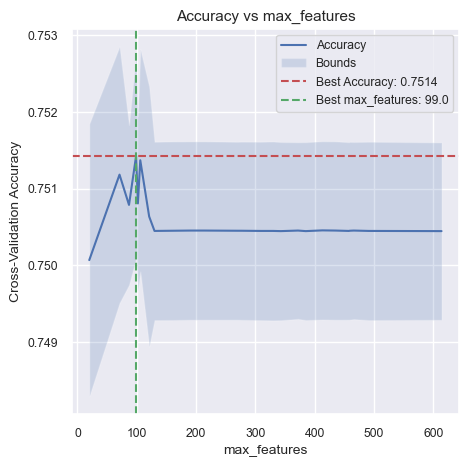

In [34]:
import matplotlib.pyplot as plt

result_df = result_df.replace([np.inf, -np.inf], np.nan)

# Determine the value of the best n_estimators and corresponding accuracy
best_value = result_df.loc[result_df['Accuracy'].idxmax()][key_parameter]
best_accuracy = result_df.loc[result_df['Accuracy'].idxmax()]['Accuracy']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(5,5))

# Plot the mean test score
ax.plot(result_df[key_parameter], result_df['Accuracy'], label='Accuracy')

# Add the lower and upper bounds
ax.fill_between(result_df[key_parameter], result_df['lower_band'], result_df['upper_band'], alpha=0.2, label='Bounds')

# Add a horizontal line for the best accuracy
ax.axhline(y=best_accuracy, color='r', linestyle='--', label='Best Accuracy')

# Add a vertical line for the best n_estimators
ax.axvline(x=best_value, color='g', linestyle='--', label='Best n_estimators')

# Set the x and y axis labels
ax.set_xlabel(key_parameter, fontsize=10)
ax.set_ylabel('Cross-Validation Accuracy', fontsize=10)

# Add a title
ax.set_title(f'Accuracy vs {key_parameter}', fontsize=11)

# Add a legend with best values
ax.legend(['Accuracy', 'Bounds', f'Best Accuracy: {best_accuracy:.4f}', f'Best {key_parameter}: {best_value}'])

# Display the plot
plt.show();


In [35]:
t_end = time.time()
total_runtime_min = calculate_duration(t_start, t_end);


if not FASTRUN: send_push(f"{notebook_no}: Sensitivity analysis finished in: {total_runtime_min}")


1780.88 minutes


# Export

In [36]:
# Save the figure
if not FASTRUN:
     plt.savefig(ROOT_PATH+PATH_DATA_FIG+f'{today}_sensitivity-analysis_RF_{key_parameter}_chart_07.02.png');


<Figure size 1200x800 with 0 Axes>

In [37]:
if not FASTRUN:
    result_df.to_csv(ROOT_PATH+PATH_DATA_REP+f'{today}_sensitivity-analysis_RF_{key_parameter}_table_07.02.csv', index=False);


# Watermark

In [38]:
%watermark

Last updated: 2023-02-26T23:39:55.866159+01:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.8.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 13, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [39]:
%watermark --iversions

numpy     : 1.24.1
matplotlib: 3.6.3
pandas    : 1.5.3
seaborn   : 0.12.2



-----


In [40]:
output_file = f'{ROOT_PATH}{PATH_DATA_HTML}{today}_07.02_model_evaluation_sensitivity_analysis_RF-max_features.html'
!jupyter nbconvert --to html "07.02_model_evaluation_sensitivity_analysis_RF-max_features.ipynb" --output {output_file}

[NbConvertApp] Converting notebook 08.02_sensitivity_analysis_RF-max_features.ipynb to html
[NbConvertApp] Writing 637779 bytes to ..\reports\html\2023-02-25_08.02_sensitivity_analysis_RF-max_features.html
